# Waypoint Processing

In [1]:
import os
import sys
import glob
import joblib
import pathlib
import numpy as np
import pandas as pd
from rich.progress import track

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../src")

from utils import timer
from utils import load_pickle, dump_pickle, save_cache

## Load single txt file

In [2]:
def get_data_from_pathtxt(
    filepath: pathlib.PosixPath, data_type: str, is_join_ids: bool = False
) -> np.ndarray:
    with open(filepath) as f:
        lines = f.readlines()

    data = []
    for line in lines:
        tmp = line.strip().split("\t")
        if tmp[1] == data_type:
            data.append(tmp)

    data = np.array(data)
    # Drop data_type column.
    if data.shape[0] > 0:
        data = np.delete(data, 1, axis=1)
    # Concatenate site, floor and path.
    if is_join_ids:
        site_id = filepath.parent.parent.name
        floor_id = filepath.parent.name
        path_id = filepath.name.split(".")[0]
        site_floor_path = np.tile([site_id, floor_id, path_id], (data.shape[0], 1))
        data = np.concatenate([site_floor_path, data], axis=1)
    return data

In [3]:
path_filepath = pathlib.Path(
    '../data/raw/train/5da138764db8ce0c98bcaa46/F4/5dac3df0dc3e2c0006606b3e.txt'
)

dst = get_data_from_pathtxt(path_filepath, "TYPE_WAYPOINT", False)

In [4]:
dst

array([['1571568985002', '29.692596', '118.90696'],
       ['1571568990444', '28.90127', '117.50295'],
       ['1571568992828', '28.358011', '115.68253'],
       ['1571568995554', '26.969471', '116.58689'],
       ['1571568999714', '25.389723', '118.57103'],
       ['1571569002481', '23.423433', '118.2902'],
       ['1571569006220', '22.45383', '117.05488'],
       ['1571569022945', '27.474419', '111.61706'],
       ['1571569028836', '27.742975', '105.953415'],
       ['1571569032941', '28.253422', '102.32324'],
       ['1571569046289', '34.950783', '101.06627'],
       ['1571569052065', '37.859444', '101.312035'],
       ['1571569057272', '36.732643', '103.068504'],
       ['1571569067504', '37.400402', '106.16084'],
       ['1571569077016', '29.686214', '105.78036'],
       ['1571569079313', '27.742975', '105.953415']], dtype='<U13')

## Load all txt files

In [5]:
def get_data_from_pathtxt(
    filepath: pathlib.PosixPath, data_type: str, is_join_ids: bool = False
) -> np.ndarray:
    with open(filepath) as f:
        lines = f.readlines()

    data = []
    for line in lines:
        tmp = line.strip().split("\t")
        if tmp[1] == data_type:
            data.append(tmp)

    data = np.array(data)
    # Drop data_type column.
    if data.shape[0] > 0:
        data = np.delete(data, 1, axis=1)
    # Concatenate site, floor and path.
    if is_join_ids:
        site_id = filepath.parent.parent.name
        floor_id = filepath.parent.name
        path_id = filepath.name.split(".")[0]
        site_floor_path = np.tile([site_id, floor_id, path_id], (data.shape[0], 1))
        data = np.concatenate([site_floor_path, data], axis=1)
    return data

In [6]:
def create_train_waypoint():
    src_dir = pathlib.Path("../data/raw/train/")
    data = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(get_data_from_pathtxt)(path_filepath, "TYPE_WAYPOINT", True)
        for site_filepath in src_dir.glob("*")
        for floor_filepath in site_filepath.glob("*")
        for path_filepath in floor_filepath.glob("*")
    )
    waypoint = np.concatenate(data, axis=0)
    return waypoint

In [7]:
%%time

waypoint = create_train_waypoint()

CPU times: user 6.91 s, sys: 965 ms, total: 7.88 s
Wall time: 2min 13s


In [8]:
data = waypoint[:, [0, 1, 4, 5]].copy()

In [9]:
unique_data, unique_idx = np.unique(data, axis=0, return_index=True)

In [10]:
print('全データの数：', data.shape[0])
print('site, floor, x, y のユニーク数：', unique_data.shape[0])

全データの数： 166683
site, floor, x, y のユニーク数： 67644


## Check leakly by timestamp

In [11]:
df = pd.DataFrame(waypoint, columns=['site', 'floor', 'path', 'start_timestamp', 'start_x', 'start_y'])
df = df.sort_values(by=['site', 'floor', 'path', 'start_timestamp'])

df['start_x'] = df['start_x'].astype(float)
df['start_y'] = df['start_y'].astype(float)
df['start_timestamp'] = df['start_timestamp'].astype(float)

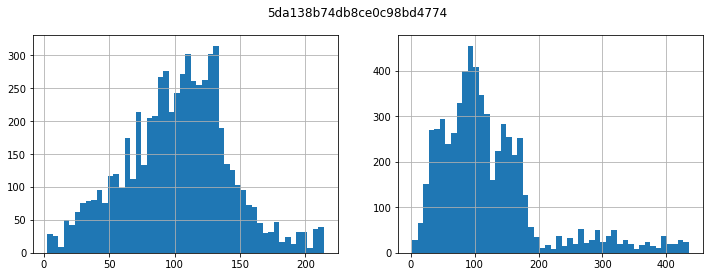

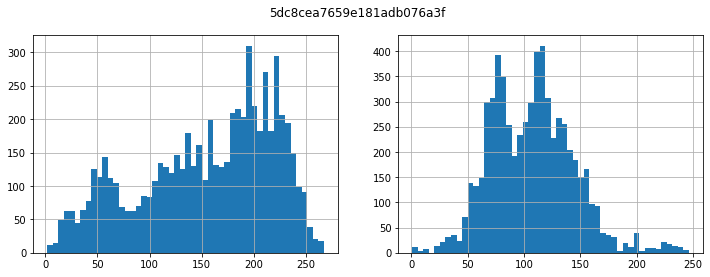

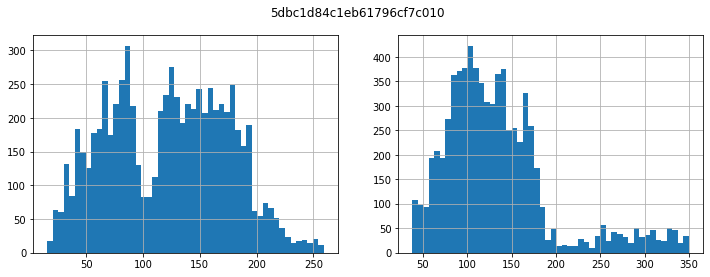

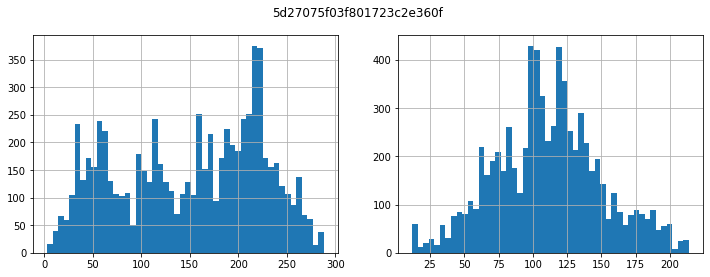

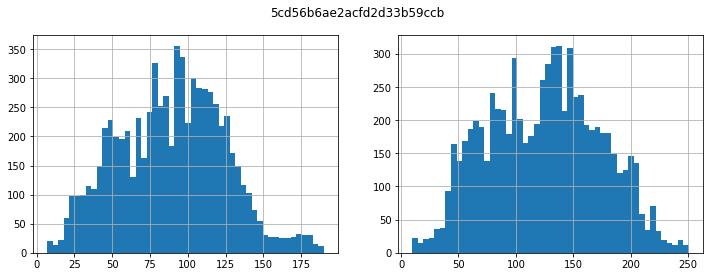

In [12]:
for site_id in df['site'].value_counts().sort_values().index[-5:]:
    plt.figure(figsize=(12, 4))
    plt.suptitle(site_id)

    plt.subplot(1,2,1)
    df.loc[df['site']==site_id, 'start_x'].hist(bins=50)

    plt.subplot(1,2,2)
    df.loc[df['site']==site_id, 'start_y'].hist(bins=50)
    
    plt.show()

In [13]:
%%time
dfs = []

for path, gdf in track(df.groupby('path')):
    first_row = gdf.head(1)   
    first_row = first_row.assign(
        end_timestamp=gdf.tail(1)['start_timestamp'].values,
        end_x=gdf.tail(1)['start_x'].values,
        end_y=gdf.tail(1)['start_y'].values,
    )
    
    dfs.append(first_row.to_numpy()[0])

Output()

CPU times: user 37.3 s, sys: 3.54 s, total: 40.8 s
Wall time: 38.2 s


In [14]:
dropped_df = pd.DataFrame(
    dfs, 
    columns=['site', 'floor', 'path', 'start_timestamp', 'start_x', 'start_y','end_timestamp', 'end_x', 'end_y']
)

dropped_df['start_x'] = dropped_df['start_x'].astype(float)
dropped_df['start_y'] = dropped_df['start_y'].astype(float)
dropped_df['end_x'] = dropped_df['end_x'].astype(float)
dropped_df['end_y'] = dropped_df['end_y'].astype(float)

dropped_df['start_timestamp'] = dropped_df['start_timestamp'].astype(float)
dropped_df['end_timestamp'] = dropped_df['end_timestamp'].astype(float)

In [15]:
dropped_df['ts_diff'] = dropped_df['start_timestamp'] - dropped_df['end_timestamp'].shift(1)

In [16]:
dropped_df.sort_values(by=['site', 'start_timestamp', 'end_timestamp']).head(50)

,site,floor,path,start_timestamp,start_x,start_y,end_timestamp,end_x,end_y,ts_diff
13637,5a0546857ecc773753327266,F3,5d10a1669c50c70008fe8977,1.561369e+12,78.218190,38.999737,1.561369e+12,91.646580,40.626476,256116013.0
13638,5a0546857ecc773753327266,F3,5d10a167f9037900086afc39,1.561369e+12,93.015305,41.108940,1.561369e+12,93.491486,47.822014,9716.0
13639,5a0546857ecc773753327266,F3,5d10a1699c50c70008fe8979,1.561369e+12,93.491486,47.822014,1.561369e+12,99.770940,82.163605,23613.0
13641,5a0546857ecc773753327266,F3,5d10a16af9037900086afc3b,1.561369e+12,99.770940,82.163605,1.561369e+12,105.347984,112.964680,-743241.0
13640,5a0546857ecc773753327266,F3,5d10a16a9c50c70008fe897b,1.561370e+12,20.052908,63.259550,1.561370e+12,27.811193,64.970850,830074.0
13643,5a0546857ecc773753327266,F3,5d10a16bf9037900086afc3d,1.561370e+12,26.549215,66.626360,1.561370e+12,36.402054,75.415886,-41205.0
13642,5a0546857ecc773753327266,F3,5d10a16b9c50c70008fe897d,1.561370e+12,38.042835,73.705740,1.561370e+12,47.369923,60.371765,734985.0
13644,5a0546857ecc773753327266,F3,5d10a16cf9037900086afc3f,1.561370e+12,33.666656,54.272750,1.561370e+12,50.123775,56.300995,490645.0
13645,5a0546857ecc773753327266,F3,5d11941affe23f0008604e2a,1.561376e+12,50.123775,56.300995,1.561376e+12,80.681400,39.265667,5144306.0
13646,5a0546857ecc773753327266,F3,5d11941c9c50c70008fe898d,1.561376e+12,78.469894,30.721445,1.561376e+12,86.488045,25.981680,22311.0


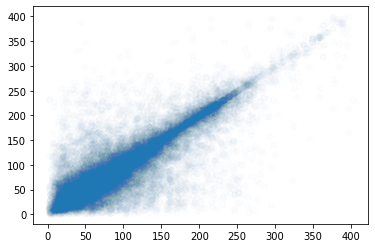

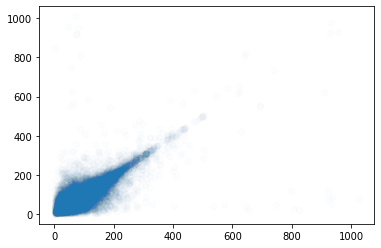

In [17]:
start_x = dropped_df['start_x'].values[:-1]
end_x = dropped_df['end_x'].values[1:]

plt.figure()
plt.scatter(x=start_x, y=end_x, alpha=0.01)
plt.show()


start_y = dropped_df['start_y'].values[:-1]
end_y = dropped_df['end_y'].values[1:]

plt.figure()
plt.scatter(x=start_y, y=end_y, alpha=0.01)
plt.show()

### 結果

- リークはしている
    - 完全に数値が一致しているもの、ほとんど同じ数値のもの、全く違う数値のもの。がある
- 同じ path, 異なる timestamp で同じ座標のデータが存在する
- 異なる path, 同じ timestamp で同じ座標のデータが存在する


上記から言えることは、


- pathファイルは、１つの大きなサンプルをいくつかに分割したものである可能性がある
- 同じpathファイル内に同じ座標データがあることから動かずにwaypointを計測することもある
    - また、上記のようなケースでファイルが分割されていることも考えられる
- 計測開始地点や終点？が指定されたものである可能性がある
    
    
#### リークの可能性がある条件

ただし、testデータにおいて既知の情報に限る

- site が同じ
- timestampが近い
- 直前の以下のパラメーターの値が似ている
    - TYPE_ACCELEROMETER
    - TYPE_GYROSCOPE
    - TYPE_MAGNETIC_FIELD
    - TYPE_ROTATION_VECTOR
    - etc

## Test の timestamp を beacon の timestamp から復号

TODO:

- [ ] timestamp の復号
- [ ] train と test の timestamp が混ざっているのが、分離しているのか可視化する

## Train と Test の時系列の関係

In [18]:
def create_test_waypoint():
    waypoint = pd.read_csv("../data/raw/sample_submission.csv")
    waypoint[["site", "path", "timestamp"]] = waypoint["site_path_timestamp"].str.split(
        "_", expand=True
    )
    waypoint.drop(["site_path_timestamp"], axis=1, inplace=True)

    waypoint = waypoint[["site", "floor", "path", "timestamp", "x", "y"]].astype(str)
    waypoint = waypoint.to_numpy()
    return waypoint

In [19]:
%%time 

train_waypoint = create_train_waypoint()
test_waypoint = create_test_waypoint()

CPU times: user 5.35 s, sys: 689 ms, total: 6.04 s
Wall time: 1min 54s


In [20]:
test_wp_df = pd.DataFrame(test_waypoint, columns=['site', 'floor', 'path', 'timestamp', 'x', 'y'])

In [21]:
test_wp_df

,site,floor,path,timestamp,x,y
0,5a0546857ecc773753327266,0,046cfa46be49fc10834815c6,0000000000009,75.0,75.0
1,5a0546857ecc773753327266,0,046cfa46be49fc10834815c6,0000000009017,75.0,75.0
2,5a0546857ecc773753327266,0,046cfa46be49fc10834815c6,0000000015326,75.0,75.0
3,5a0546857ecc773753327266,0,046cfa46be49fc10834815c6,0000000018763,75.0,75.0
4,5a0546857ecc773753327266,0,046cfa46be49fc10834815c6,0000000022328,75.0,75.0
...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f,0,fd64de8c4a2fc5ebb0e9f412,0000000082589,75.0,75.0
10129,5dc8cea7659e181adb076a3f,0,fd64de8c4a2fc5ebb0e9f412,0000000085758,75.0,75.0
10130,5dc8cea7659e181adb076a3f,0,fd64de8c4a2fc5ebb0e9f412,0000000090895,75.0,75.0
10131,5dc8cea7659e181adb076a3f,0,fd64de8c4a2fc5ebb0e9f412,0000000096899,75.0,75.0


<AxesSubplot:>

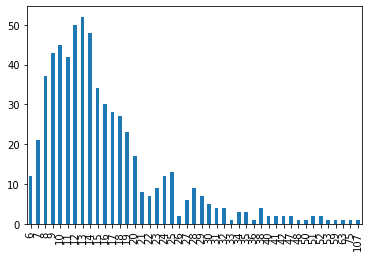

In [22]:
test_wp_df['path'].value_counts().value_counts().sort_index().plot.bar()